In [1]:
import numpy as np
from datetime import datetime
from datetime import timedelta
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from itertools import cycle

In [2]:
GRID_N_DAYS = 3500
BASE_DATE = datetime(2019,1,1)
lines = ["-","--","-.",":"]

In [3]:
def populate(grid, start_date, end_date, labor_days):

    assert end_date > start_date, f'start date {start_date} is less than or equal to end date {end_date}'
    
    start_offset_days = (start_date - BASE_DATE).days
    end_offset_days = (end_date - BASE_DATE).days
    
    days_in_period = end_offset_days - start_offset_days
    
    assert labor_days <= days_in_period, (f'start date {start_date}, end date {end_date}:'
                                          f'the number of labor days {labor_days}'
                                          ' is greater than or equal to '
                                          f'the number of actual days in period {days_in_period}')
    
    avg_time_spent = labor_days/days_in_period
    
    grid[start_offset_days: end_offset_days] += avg_time_spent
    
    delta_grid = np.zeros(GRID_N_DAYS)
    delta_grid[start_offset_days: end_offset_days] += avg_time_spent

    return delta_grid


In [21]:
def check_member(df, team_member, member_load = 0.85):
    print(f'Checking member {team_member}..')
    if df[team_member].isnull().values.any():
        print(f'Found a nan value for row {df[df[team_member].isnull()]}')
    grid = np.zeros(GRID_N_DAYS)
    all_ok = True
    delta_list = []
    last_grid_bad = []
    for index, row in df.iterrows():
        start_date = datetime.strptime(row['Start'], '%Y-%m-%d')
        end_date = datetime.strptime(row['Finish'], '%Y-%m-%d')
        labor_days = row[team_member]
        #print(f'Checking {start_date} to {end_date} and days {labor_days}')
        delta = populate(grid, start_date, end_date, labor_days)
        # Check if there are grid points that exceed tolerance
        # And there's a change since the previous loop
        grid_bad = grid[grid > member_load]
        if (grid_bad).size > 0 and not np.array_equal(grid_bad, last_grid_bad):
            last_grid_bad = grid_bad
            print(f'PROBLEM: adding date range {start_date} to {end_date} results in max daily work being exceeded')
            all_ok = False
        delta_list.append(delta)
    if all_ok:
        print(f'OK for member {team_member}')
    else:
        print(f'PROBLEMS found for member {team_member}')
    return grid, delta_list

In [22]:
def plot_loading(grid, delta_list):
    date_list = [BASE_DATE + timedelta(days=i) for i in range(GRID_N_DAYS)]
    dates = matplotlib.dates.date2num(date_list)

    xrange = matplotlib.dates.date2num([datetime(2020,1,1), datetime(2022,1,1)])
    plt.figure(figsize=(20,10))
    plt.xticks(rotation=90)
    #linecycler = cycle(lines)
    for counter, delta in enumerate(delta_list):
        plt.plot_date(dates, delta.tolist(), label=df['Task'][counter])
    plt.plot_date(dates, grid.tolist(), label='Total')
    plt.legend(loc="upper left")
    #plt.xlim(xrange[0], xrange[1])
    plt.xlim('2020-09-01', '2021-09-01')


    

In [35]:
df = pd.read_csv('drp-plan-worst-case2.csv', skipinitialspace=True, quotechar='"' ).applymap(lambda x: x.strip() if type(x)==str else x)


In [36]:
for member, load in [('Price', 0.9), ('Caplar', 0.6), ('Belland', 0.5), ('Yasuda', 0.5), ('Yabe', 0.5), ('Yamashita', 0.5), ('Mineo', 0.5), ('Hamano', 0.5), ('PU-2', 0.9)]:
    check_member(df, member)

Checking member Price..
OK for member Price
Checking member Caplar..
OK for member Caplar
Checking member Belland..
OK for member Belland
Checking member Yasuda..
OK for member Yasuda
Checking member Yabe..
OK for member Yabe
Checking member Yamashita..
OK for member Yamashita
Checking member Mineo..
OK for member Mineo
Checking member Hamano..
OK for member Hamano
Checking member PU-2..
OK for member PU-2


In [37]:
grid, delta_list = check_member(df, 'Price', 0.9)

Checking member Price..
OK for member Price


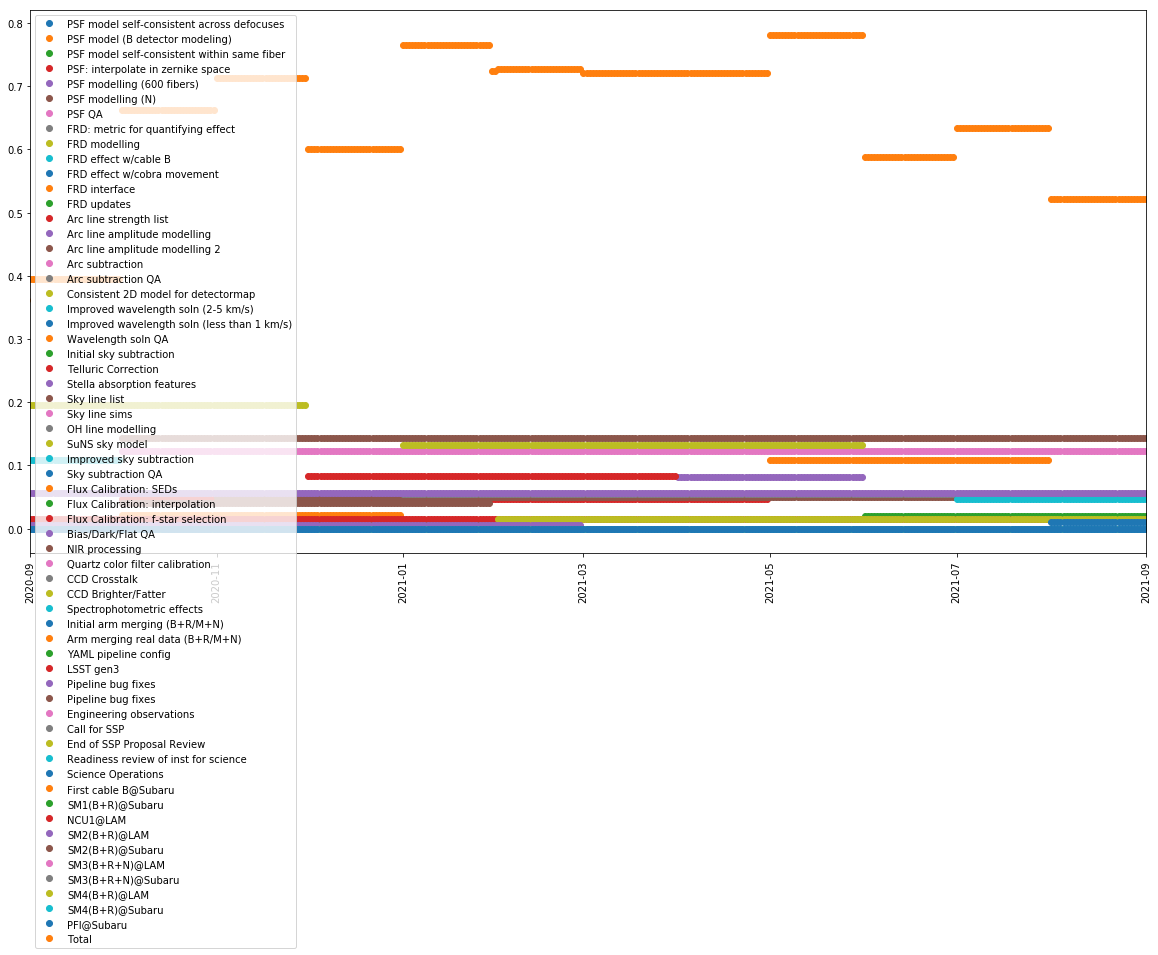

In [38]:
plot_loading(grid, delta_list)


In [39]:
grid[grid>1]

array([], dtype=float64)

Checking member Caplar..
PROBLEM: adding date range 2019-09-01 00:00:00 to 2021-01-01 00:00:00 results in max daily work being exceeded
PROBLEM: adding date range 2020-10-01 00:00:00 to 2021-01-01 00:00:00 results in max daily work being exceeded
PROBLEM: adding date range 2020-10-01 00:00:00 to 2022-02-01 00:00:00 results in max daily work being exceeded
PROBLEM: adding date range 2021-02-01 00:00:00 to 2022-12-01 00:00:00 results in max daily work being exceeded
PROBLEM: adding date range 2021-01-01 00:00:00 to 2021-10-01 00:00:00 results in max daily work being exceeded
PROBLEMS found for member Caplar


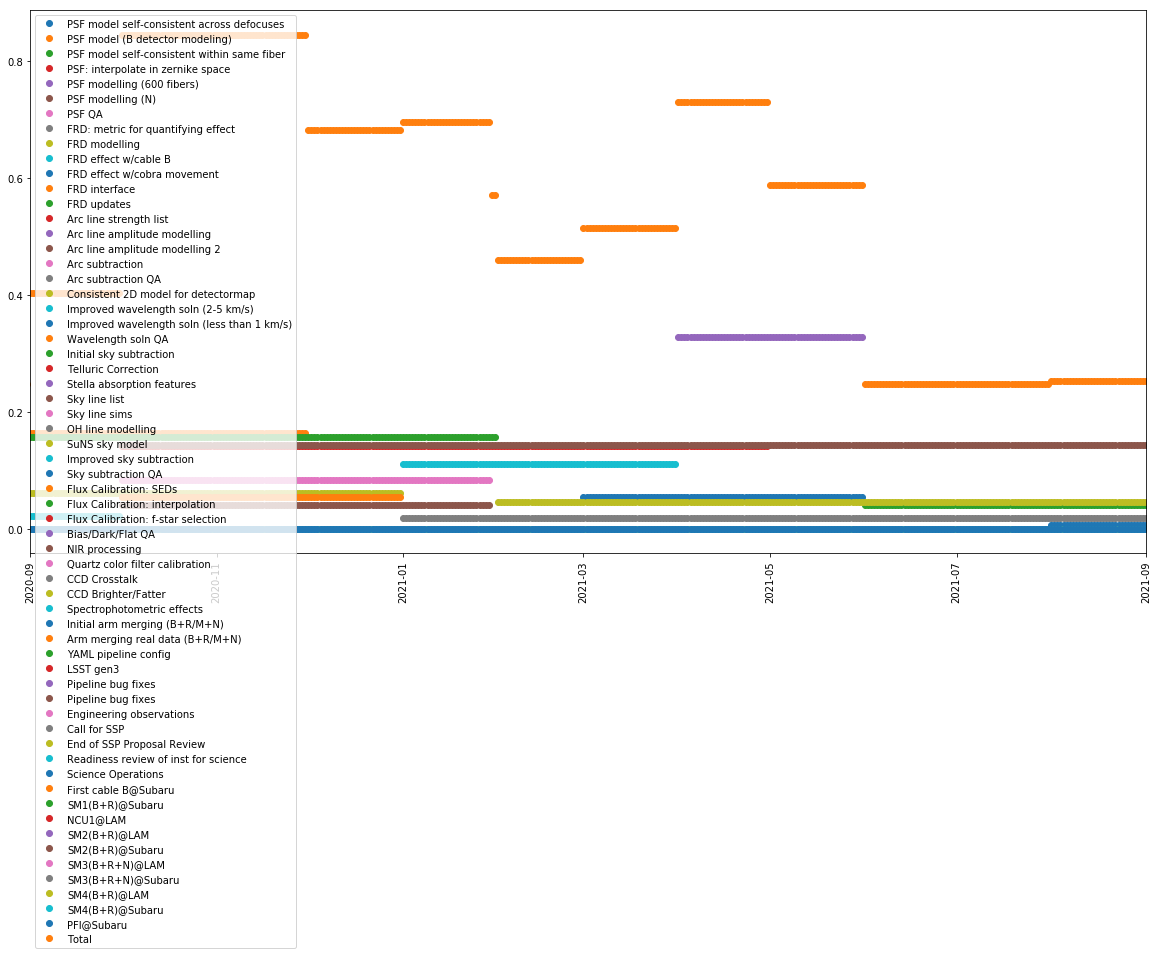

In [40]:
grid, delta_list = check_member(df, 'Caplar', 0.6)
plot_loading(grid, delta_list)